In [119]:
from pylab import *
import os
from IPython.display import Image
import matplotlib.pyplot as plt
import matplotlib.image as img
from numpy import random
import cv2 as cv
import pandas as pd

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.preprocessing.image import ImageDataGenerator  # for auto-labelling the datasets based on the folders they are in
from tensorflow.keras.preprocessing import image

from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

In [2]:
training_path = "/kaggle/input/landscape-classifier/Landscape_classifier_02/training/"
testing_path = "/kaggle/input/landscape-classifier/Landscape_classifier_02/testing/"
prediction_path = "/kaggle/input/landscape-classifier/Landscape_classifier_02/prediction/"
prediction_path_0 = "/kaggle/input/landscape-classifier/Landscape_classifier_02/prediction/prediction/"

In [3]:
# pick randomly images from prediction dataset to obtain knowledge about the sizes of the images

image0 = cv.imread(prediction_path_0+os.listdir(prediction_path_0)[random.randint(0,len(os.listdir(prediction_path_0)))])
image0.shape

# which says all images are RGB and 150*150

(150, 150, 3)

In [87]:
def visualize(K,row_num, col_num):    # An image visualization function
    image_store = []
    img_loc = []
    for i in range(0,row_num*col_num):
        image_store.append(K+os.listdir(K)[i])
        
    for item in image_store:
        img_loc.append(cv.imread(item))
    f, axarr = plt.subplots(row_num, col_num,figsize=(14,14))
    f.tight_layout()
    f.suptitle("Images in Prediction dataset",size=18,fontweight="bold")
    f.subplots_adjust(top=0.95)
    
    for i in range(0, row_num*col_num):
        axarr[int(i/col_num),int(i%col_num)].imshow(img_loc[i])
        

def PlotAccuracy(Hist):
    plt.plot(Hist.history['accuracy'])
    plt.plot(Hist.history['val_accuracy'])
    plt.title('model accuracy')
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend(['train', 'val'], loc='upper left')
    plt.show()
    
    
def PlotLoss(Hist):
    plt.plot(Hist.history['loss'])
    plt.plot(Hist.history['val_loss'])
    plt.title('model loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'val'], loc='upper left')
    plt.show()
    
    
def PlotTrainBehaviour(Hist):
    PlotAccuracy(Hist)
    PlotLoss(Hist)
    
    
def PrintProgress(Hist):
    init_training_accuracy = Hist.history['accuracy'][0] * 100
    end_training_accuracy = Hist.history['accuracy'][len(Hist.history['accuracy'])-1] * 100

    init_val_accuracy = Hist.history['val_accuracy'][0] * 100
    end_val_accuracy = Hist.history['val_accuracy'][len(Hist.history['accuracy'])-1] * 100

    print("\n")                                                           
    print("Evolution of Training Accuracy : " + str(init_training_accuracy) + " % --> " + str(end_training_accuracy) + " % \n")
    print("Evolution of Validation Accuracy : " + str(init_val_accuracy) + " % --> " + str(end_val_accuracy)+" % \n")

    print("training terminated at : "+str(len(Hist.history['loss']))+"-th epoch \n")
    

def print_label(softmaxed_prob):
    num = np.argmax(softmaxed_prob)
    if num==0:
        print('buildings')
    if num==1:
        print('forest')
    if num==2:
        print('glacier')
    if num==3:
        print('mountain')
    if num==4:
        print('sea')
    if num==5:
        print('street')

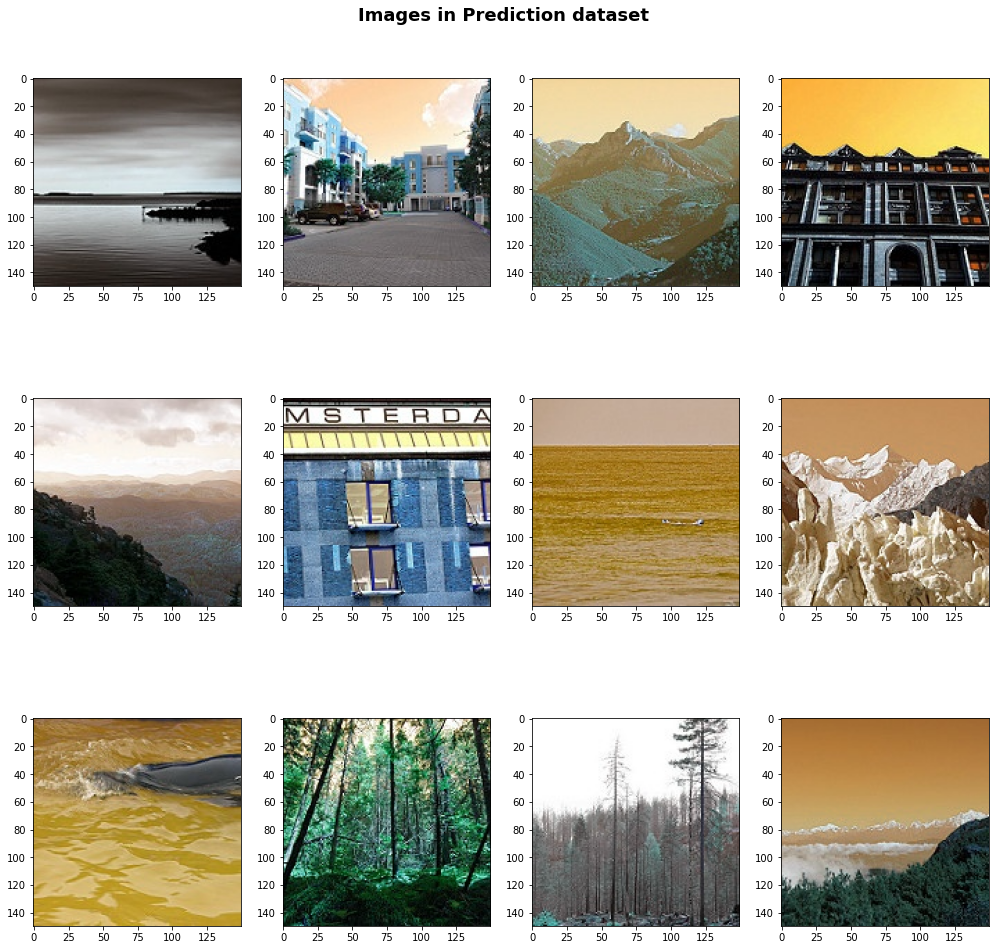

In [148]:
visualize(prediction_path_0, 3, 4)

In [5]:
train = ImageDataGenerator(rescale=1.0/255.0)
validation = ImageDataGenerator(rescale=1.0/255.0)
prediction = ImageDataGenerator(rescale=1.0/255.0) 


training_dataset = train.flow_from_directory(training_path,        # although all the images are of equal size 150*150 - we can still scale it down to 100*100 due to general practice
											target_size=(150,150),
											batch_size = 10,
											class_mode='categorical')

validation_dataset = validation.flow_from_directory(testing_path,
											target_size=(150,150),
											batch_size = 10,
											class_mode='categorical')

prediction_dataset = prediction.flow_from_directory(prediction_path,
                                                    target_size=(150,150),
                                                    batch_size = 1,
                                                    class_mode='categorical')

Found 14034 images belonging to 6 classes.
Found 3000 images belonging to 6 classes.
Found 7301 images belonging to 1 classes.


In [ ]:
# # Getting the accuracy
# accuracy = accuracy_score(training_dataset.classes[:len(prediction_dataset)], predicted_class_indices)
# print("Accuracy: ", accuracy)

# # Getting the confusion matrix
# cm = confusion_matrix(training_dataset.classes[:len(prediction_dataset)], predicted_class_indices)
# print("Confusion Matrix: ", cm)

# # Getting the classification report
# cr = classification_report(training_dataset.classes[:len(prediction_dataset)], predicted_class_indices)
# print("Classification Report: ", cr)

In [54]:
len(prediction_dataset)

7301

In [73]:
training_dataset.class_indices

{'buildings': 0,
 'forest': 1,
 'glacier': 2,
 'mountain': 3,
 'sea': 4,
 'street': 5}

In [6]:
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'

## the architecture :

#### [1](CONV - ReLU)-MAXPOOL - [2](CONV - ReLU)-MAXPOOL - [3](CONV - ReLU)-MAXPOOL - [4](CONV - ReLU)-MAXPOOL - (FC[1024] - ReLU) - (FC[512] - ReLU) - (FC[6] - SOFTMAX) 

## Convolutional Network

In [7]:
tf.random.set_seed(0)

conv_1_input = layers.Conv2D(64, (4, 4), activation='relu', input_shape=(150, 150, 3), kernel_regularizer='l2')
max_pool_1 = layers.MaxPooling2D((2, 2))

conv_2 = layers.Conv2D(64, (3, 3), activation='relu', kernel_regularizer='l2')
max_pool_2 = layers.MaxPooling2D((2, 2))

conv_3 = layers.Conv2D(64, (3, 3), activation='relu', kernel_regularizer='l2')
max_pool_3 = layers.MaxPooling2D((2, 2))

conv_4 = layers.Conv2D(32, (2, 2), activation='relu', kernel_regularizer='l2')
max_pool_4 = layers.MaxPooling2D((2, 2))

flatten = layers.Flatten()

dense_1 = layers.Dense(1024, activation='relu',  kernel_regularizer='l2')   # Implementing L2 Regularization (eventual_squared-weight-decay during training)
dense_2 = layers.Dense(512, activation='relu',  kernel_regularizer='l2')
dense_out = layers.Dense(6, activation='softmax')

small_dropout = layers.Dropout(0.30)
medium_dropout = layers.Dropout(0.55)


inputs = layers.Input(shape=(150, 150, 3))
x = conv_1_input(inputs)
x = max_pool_1(x)

x = conv_2(x)
x = max_pool_2(x)

x = conv_3(x)
x = max_pool_3(x)

x = conv_4(x)
x = max_pool_4(x)

x = flatten(x)
x = small_dropout(x)

x = dense_1(x)
x = medium_dropout(x)

x = dense_2(x)
x = medium_dropout(x)

outputs = dense_out(x)


model_CNN = keras.Model(inputs = inputs, outputs = outputs, name='prikarsartams_regularised_CNN')

print(model_CNN.summary())

Model: "prikarsartams_regularised_CNN"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 150, 150, 3) 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 147, 147, 64) 3136        input_1[0][0]                    
__________________________________________________________________________________________________
max_pooling2d (MaxPooling2D)    (None, 73, 73, 64)   0           conv2d[0][0]                     
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 71, 71, 64)   36928       max_pooling2d[0][0]              
______________________________________________________________________

In [9]:
model_CNN.compile(loss='categorical_crossentropy',
                optimizer= tf.keras.optimizers.Adagrad(              # Using Adaptive Gradient Algorithm - Adagrad 
                             learning_rate=0.001,
                             initial_accumulator_value=0.1,
                             epsilon=1e-07,
                             name="Adagrad"),
                metrics=['accuracy'])

In [10]:
%%time
early_stop = tf.keras.callbacks.EarlyStopping(monitor='loss', patience=10)  # Earlystop Implementation 

history_cnn = model_CNN.fit(training_dataset, validation_data = validation_dataset, epochs=500, verbose=1, callbacks=[early_stop])   # calling Earlystop as callback during the break in between the epochs

Epoch 1/500
1404/1404 [==============================] - 70s 44ms/step - loss: 21.0148 - accuracy: 0.2129 - val_loss: 19.3260 - val_accuracy: 0.4147
Epoch 2/500
1404/1404 [==============================] - 31s 22ms/step - loss: 17.6690 - accuracy: 0.3871 - val_loss: 16.0811 - val_accuracy: 0.5123
Epoch 3/500
1404/1404 [==============================] - 31s 22ms/step - loss: 14.9981 - accuracy: 0.4773 - val_loss: 13.8159 - val_accuracy: 0.5373
Epoch 4/500
1404/1404 [==============================] - 30s 22ms/step - loss: 12.9590 - accuracy: 0.5121 - val_loss: 12.0027 - val_accuracy: 0.5530
Epoch 5/500
1404/1404 [==============================] - 30s 22ms/step - loss: 11.3100 - accuracy: 0.5334 - val_loss: 10.5164 - val_accuracy: 0.5713
Epoch 6/500
1404/1404 [==============================] - 31s 22ms/step - loss: 9.9502 - accuracy: 0.5460 - val_loss: 9.2750 - val_accuracy: 0.5800
Epoch 7/500
1404/1404 [==============================] - 31s 22ms/step - loss: 8.8146 - accuracy: 0.5541 - v



Evolution of Training Accuracy : 21.291150152683258 % --> 74.84679818153381 % 

Evolution of Validation Accuracy : 41.466665267944336 % --> 75.43333172798157 % 

training terminated at : 249-th epoch 



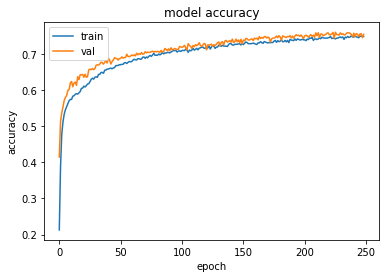

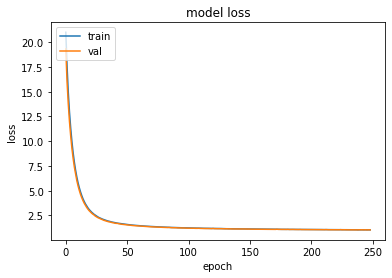

In [11]:
PrintProgress(history_cnn)
PlotTrainBehaviour(history_cnn)
model_CNN.save('/kaggle/working/model_CNN.h5')

In [92]:
prediction_0 = model_CNN.predict(prediction_dataset[5][0])
print_label(prediction_0)

mountain


In [143]:
# Predicting the Test set results
prediction_set = model_CNN.predict(prediction_dataset, steps=len(prediction_dataset), verbose=1)

# Getting the predicted class
predicted_class_indices=np.argmax(prediction_set,axis=1)

# Getting the labels
labels = (training_dataset.class_indices)
labels = dict((v,k) for k,v in labels.items())
predictions = [labels[k] for k in predicted_class_indices]

# Getting the filenames
filenames=prediction_dataset.filenames
results=pd.DataFrame({"Filename":filenames,
                      "Predictions":predictions,
                     "class_index": predicted_class_indices})
results.to_csv("results_from_CNN_0.csv",index=True)

7301/7301 [==============================] - 23s 3ms/step


In [144]:
classified_images = pd.read_csv('/kaggle/working/results_from_CNN_0.csv')  

In [147]:
print(classified_images[:20])   # showing first 20 entries from the classified image_set

    Unnamed: 0              Filename Predictions  class_index
0            0  prediction/10004.jpg         sea            4
1            1  prediction/10005.jpg      forest            1
2            2  prediction/10012.jpg         sea            4
3            3  prediction/10013.jpg    mountain            3
4            4  prediction/10017.jpg     glacier            2
5            5  prediction/10021.jpg         sea            4
6            6   prediction/1003.jpg     glacier            2
7            7  prediction/10034.jpg   buildings            0
8            8  prediction/10038.jpg     glacier            2
9            9  prediction/10040.jpg         sea            4
10          10  prediction/10043.jpg     glacier            2
11          11  prediction/10045.jpg         sea            4
12          12  prediction/10047.jpg    mountain            3
13          13  prediction/10048.jpg     glacier            2
14          14  prediction/10052.jpg     glacier            2
15      